In [1]:
import kagglehub
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

In [2]:
path = kagglehub.dataset_download("astraszab/facial-expression-dataset-image-folders-fer2013")

100%|██████████| 65.1M/65.1M [00:00<00:00, 75.9MB/s]

Extracting files...


In [3]:
train_dir = f"{path}/data/train"
val_dir = f"{path}/data/val"
test_dir = f"{path}/data/test"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
classes = train_dataset.classes

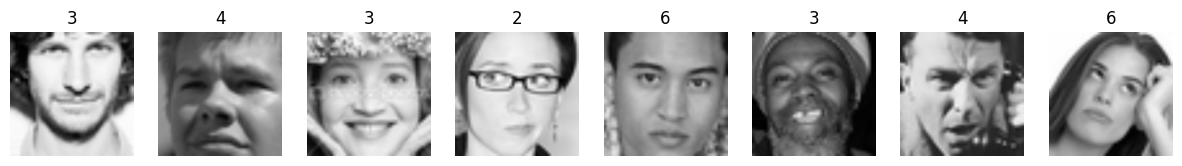

In [9]:
def visualize_data(loader, classes):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images[:8]  # Display 8 images
    labels = labels[:8]

    fig, axes = plt.subplots(1, 8, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # Unnormalize
        ax.imshow(img)
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()

visualize_data(train_loader, classes)

In [10]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # Modify output layer for 7 classes
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_accuracies, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracies.append(correct_train / total_train)

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracies.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
    return model, train_accuracies, val_accuracies

In [13]:
def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.show()

Epoch [1/10], Train Acc: 0.5251, Val Acc: 0.5704
Epoch [2/10], Train Acc: 0.6092, Val Acc: 0.6099
Epoch [3/10], Train Acc: 0.6527, Val Acc: 0.6191
Epoch [4/10], Train Acc: 0.6875, Val Acc: 0.6272
Epoch [5/10], Train Acc: 0.7446, Val Acc: 0.6344
Epoch [6/10], Train Acc: 0.8082, Val Acc: 0.6333
Epoch [7/10], Train Acc: 0.8793, Val Acc: 0.6202
Epoch [8/10], Train Acc: 0.9211, Val Acc: 0.6261
Epoch [9/10], Train Acc: 0.9412, Val Acc: 0.6180
Epoch [10/10], Train Acc: 0.9565, Val Acc: 0.6160


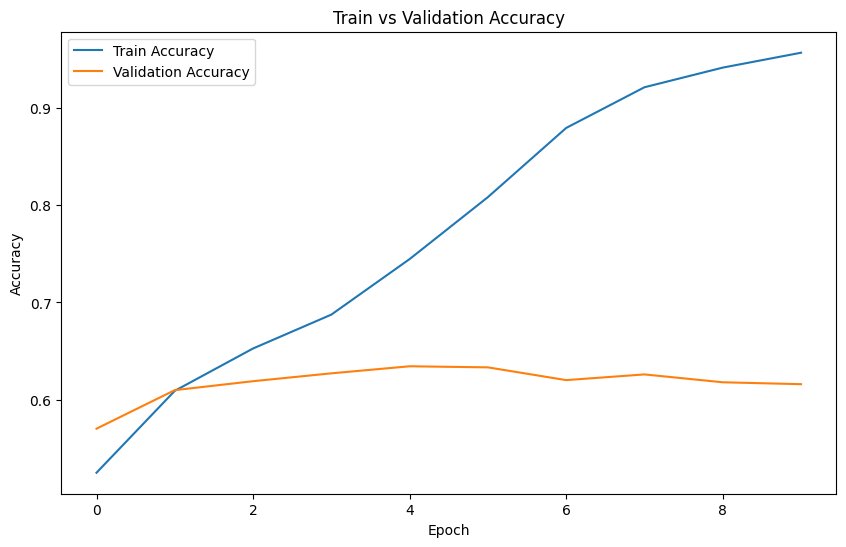

In [14]:
trained_model, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
plot_accuracies(train_accuracies, val_accuracies)

In [15]:
torch.save(trained_model.state_dict(), "resnet_emotion_recognition.pth")

In [18]:
import random
from PIL import Image
import numpy as np
# Function to predict and visualize multiple random samples with a probability meter
def predict_random_samples(model, dataset, transform, classes, num_samples=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)  # Randomly select indices
    selected_samples = [dataset[i] for i in indices]

    for image_tensor, label in selected_samples:
        # Add batch dimension and move to device
        image = image_tensor.unsqueeze(0).to(device)
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy().flatten()

        # Display probability meter
        plt.figure(figsize=(8, 4))
        plt.bar(classes, probabilities, color="skyblue")
        plt.xlabel("Emotions")
        plt.ylabel("Probability")
        plt.title(f"Predicted Emotion: {classes[np.argmax(probabilities)]} (Actual: {classes[label]})")
        plt.show()

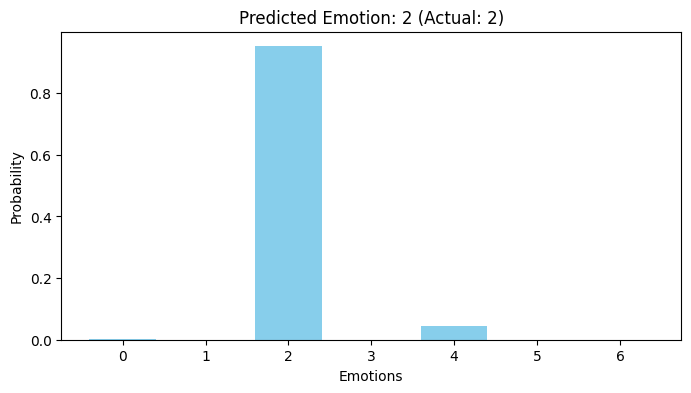

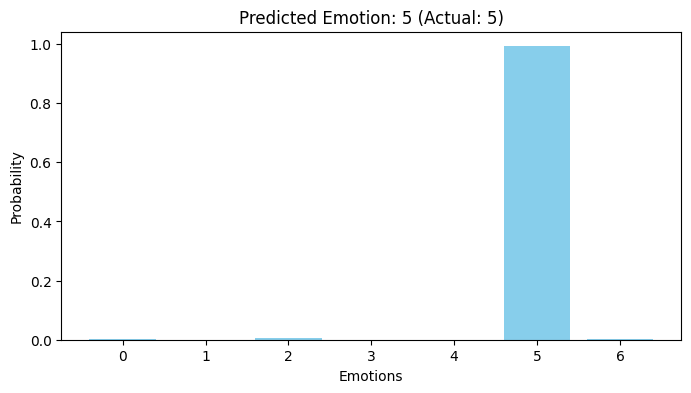

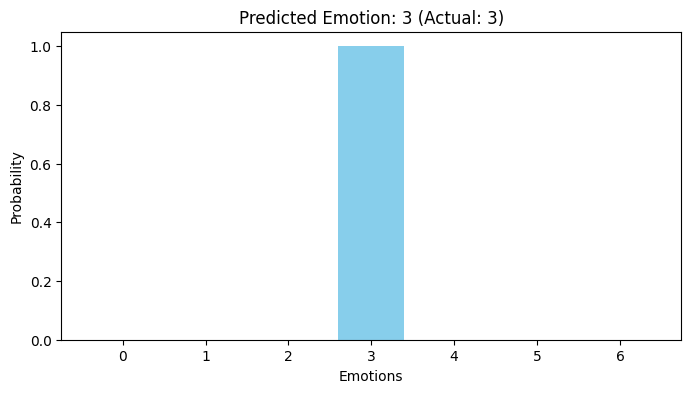

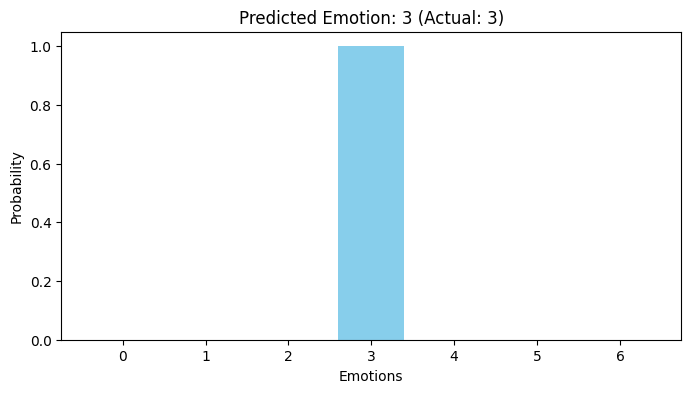

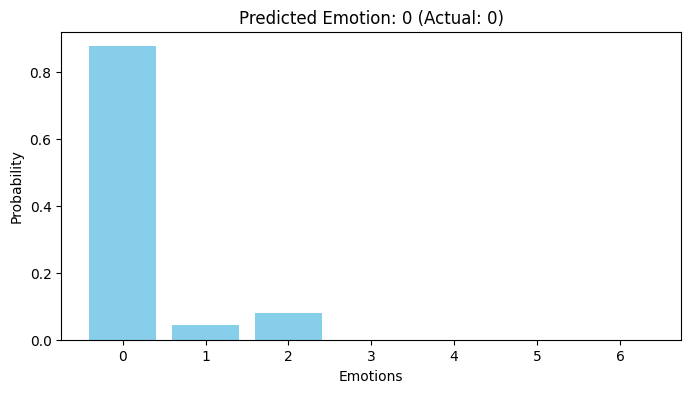

In [19]:
predict_random_samples(trained_model, test_dataset, transform, classes, num_samples=5)